- stride, padding
-> 27 
- 이미지는 필터링되지않음
- convolution

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.utils as utils
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from tensorflow.keras.datasets import mnist


# 1. Convolution 결과 이미지 확인
## (1) 샘플 이미지 준비

In [4]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test)= mnist.load_data()

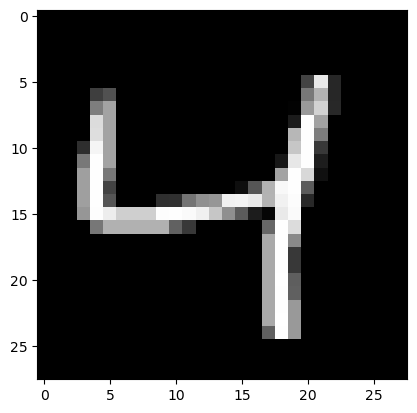

In [6]:
plt.imshow(X_train[2], cmap='gray')

## (2) 필터 준비

In [8]:
horizontal_filter = np.array([[1., 1., 1.], 
                              [0., 0., 0.], 
                              [-1., -1., -1.]])
vertical_filter = np.array([[1., 0., -1.], 
                            [1., 0., -1.], 
                            [1., 0., -1.]])
sharpen_filter = np.array([[0., -1., 0.], [-1., 5., -1.], [0., -1., 0.]])
blur_filter = np.array([[0.11, 0.11, 0.11], [0.11, 0.11, 0.11], [0.11, 0.11, 0.11]])
edge_1_filter = np.array([[1., 0., -1.], [0., 0., 0.], [-1., 0., 1.]])
edge_2_filter = np.array([[0., -1., 0.], [-1., 4., -1.], [0., -1., 0.]])
edge_3_filter = np.array([[-1., -1., -1.], [-1., 8., -1.], [-1., -1., -1.]])

## (3) Convolution 공식을 함수화

In [17]:
def conv2d_simple(input_image, filter, filter_size):
    original_image_size= input_image.shape[0]
    conv_output_size= int(((original_image_size - filter_size)/ 1 + 1)) # stride
    print(conv_output_size)
    
    filter_image= np.zeros((conv_output_size, conv_output_size))
    for i in range(conv_output_size):
        for j in range(conv_output_size):
            conv_result= input_image[i:(i+filter_size), j:(j+filter_size)] * filter 
            conv_sum= np.sum(conv_result)
            # f(x)g(x-t)
            
            if(conv_sum>255):
                conv_sum =255
                
            filter_image[i,j]= conv_sum
            
    return filter_image

In [22]:
vertical_filter_image= conv2d_simple(X_train[2], vertical_filter, 3)
horizontal_filter_image= conv2d_simple(X_train[2], horizontal_filter, 3)
sharpen_filter_image= conv2d_simple(X_train[2], sharpen_filter, 3)
blur_filter_image= conv2d_simple(X_train[2], blur_filter, 3)
edge_1_filter_image= conv2d_simple(X_train[2], edge_1_filter, 3)
edge_2_filter_image= conv2d_simple(X_train[2], edge_2_filter, 3)
edge_3_filter_image= conv2d_simple(X_train[2], edge_3_filter, 3)

26
26
26
26
26
26
26


In [19]:
print(vertical_filter_image.shape)

(26, 26)


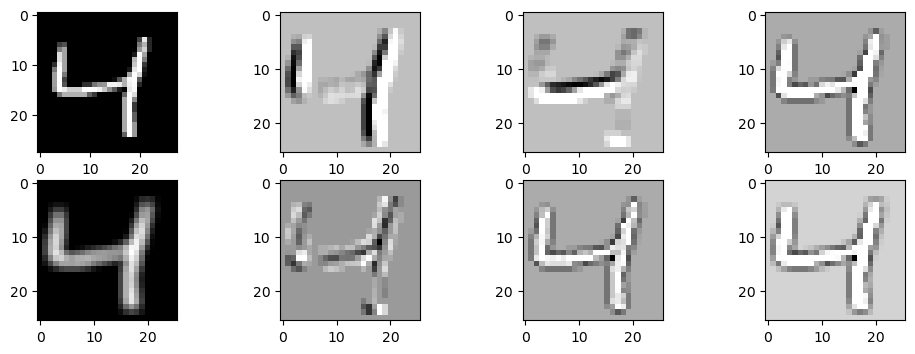

In [27]:
plt.figure(figsize=(12,4))

plt.subplot(2,4,1)
plt.imshow(X_train[2], cmap='gray')

plt.subplot(2,4,2)
plt.imshow(vertical_filter_image, cmap='gray')

plt.subplot(2,4,3)
plt.imshow(horizontal_filter_image, cmap='gray')

plt.subplot(2,4,4)
plt.imshow(sharpen_filter_image, cmap='gray')

plt.subplot(2,4,5)
plt.imshow(blur_filter_image, cmap='gray')

plt.subplot(2,4,6)
plt.imshow(edge_1_filter_image , cmap='gray')

plt.subplot(2,4,7)
plt.imshow(edge_2_filter_image, cmap='gray')

plt.subplot(2,4,8)
plt.imshow(edge_3_filter_image , cmap='gray')

## (4) Max Pooling을 함수화

In [35]:
def maxpooling2d_simple(input_image):
    image_x= input_image.shape[0]
    image_y= input_image.shape[1]
    
    new_image_x= int(image_x/2)
    new_image_y= int(image_y/2)
    
    max_pool_image= np.zeros((new_image_x, new_image_y))
    
    for x in range(0, image_x, 2):
        for y in range(0, image_y, 2):
            max_pool_image[int(x/2), int(y/2)]= np.max(input_image[x:x+2, y:y+2])
   
    return max_pool_image

In [38]:
vertical_filter_image= conv2d_simple(X_train[2], vertical_filter, 3)
print(vertical_filter_image.shape)

vertical_conv_pool_image= maxpooling2d_simple(vertical_filter_image) # 26 * 26
print(vertical_conv_pool_image.shape)

print(vertical_conv_pool_image)

origin_pool_image=maxpooling2d_simple(X_train[2])
print(origin_pool_image.shape)
print(origin_pool_image)

26
(26, 26)
(13, 13)
[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  232.   39.
     0.]
 [   0.  -62.  244.    0.    0.    0.    0.    0.    0. -187.  255.  118.
     0.]
 [   0. -407.  255.    0.    0.    0.    0.    0.    0. -285.  255.   79.
     0.]
 [   0. -323.  255.    0.    0.    0.    0.    0.    0.  255.  255.    0.
     0.]
 [   0.   88.  255.    0.    0.    0.    0.    0. -186.  255.  255.    0.
     0.]
 [   0.  205.  255.    0.  -49.   18.    0.   36. -332.  255.  255.    0.
     0.]
 [   0. -190.  242.    0.  124.  112.  107.  122. -331.  255.   40.    0.
     0.]
 [   0.    0.    0.    0.  121.   98.    0.    0.  255.  255.    0.    0.
     0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.  255.  255.    0.    0.
     0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.  164.  255.    0.    0.
     0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.  -25.  255.    0

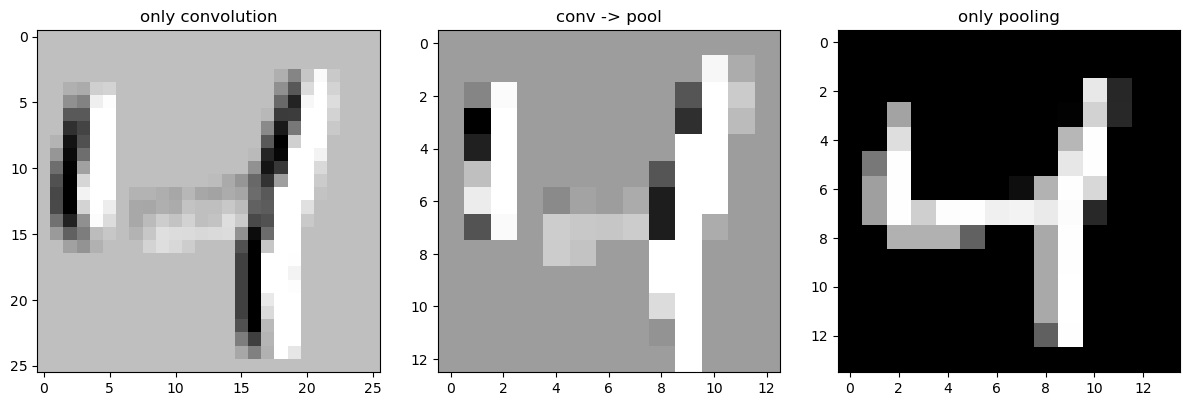

In [41]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title('only convolution')
plt.imshow(vertical_filter_image, cmap='gray')

plt.subplot(1,3,2)
plt.title("conv -> pool")
plt.imshow(vertical_conv_pool_image, cmap='gray')

plt.subplot(1,3,3)
plt.title('only pooling')
plt.imshow(origin_pool_image, cmap='gray')

plt.tight_layout()

# 2. Basic CNN
- mnist

In [2]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test)= mnist.load_data()

In [3]:
X_train= X_train/255
X_test= X_test/255

In [5]:
print(X_train.shape, X_test.shape)
# 행렬로 준비되있어야 윤곽 파악 가능

(60000, 28, 28) (10000, 28, 28)


In [7]:
?Conv2D

In [8]:
model= Sequential()

model.add(Conv2D(filters=32, kernel_size=3, strides=(1,1), input_shape=(28, 28, 1), 
                 padding='VALID', activation= 'relu')) # Conv에서는 이미지 그대로 2차원으로 받기. 그래야 특징 추출 가능
                # filters: 필터 갯수, kernel_size: 필터 사이즈

model.add(MaxPool2D(pool_size=(2,2), padding='VALID')) # pool_size: 필터의 크기

model.add(Flatten())

model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()
# Params
# 320= 32 * 3 * 3(weight) + 32(bias)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [11]:
# padding='SAME' : padding하기.
model= Sequential()

model.add(Conv2D(filters=32, kernel_size=3, strides=(1,1), input_shape=(28, 28, 1), 
                 padding='SAME', activation= 'relu')) # Conv에서는 이미지 그대로 2차원으로 받기. 그래야 특징 추출 가능
                # filters: 필터 갯수, kernel_size: 필터 사이즈

model.add(MaxPool2D(pool_size=(2,2), padding='SAME', strides=(1,1))) # pool_size: 필터의 크기

model.add(Flatten())

model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 10)                250890    
                                                                 
Total params: 251,210
Trainable params: 251,210
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(X_train.reshape(-1,28,28,1), y_train, epochs=5, validation_split=0.2) # 차원 바꾸기

Epoch 1/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.1111 - val_accuracy: 0.9819
Epoch 2/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.1165 - val_accuracy: 0.9822
Epoch 3/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1123 - val_accuracy: 0.9825
Epoch 4/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.1128 - val_accuracy: 0.9820
Epoch 5/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 0.1140 - val_accuracy: 0.9824


In [15]:
model.evaluate(X_test.reshape(-1,28,28,1), y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0929 - accuracy: 0.9845


[0.09294907748699188, 0.984499990940094]

## (2) Fashion MNIST

In [16]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test)= fashion_mnist.load_data()

In [17]:
model= Sequential()

model.add(Conv2D(filters=32, kernel_size=3, strides=(1,1), input_shape=(28, 28, 1), 
                 padding='VALID', activation= 'relu')) # Conv에서는 이미지 그대로 2차원으로 받기. 그래야 특징 추출 가능
                # filters: 필터 갯수, kernel_size: 필터 사이즈

model.add(MaxPool2D(pool_size=(2,2), padding='VALID')) # pool_size: 필터의 크기

model.add(Flatten())

model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()
# Params
# 320= 32 * 3 * 3(weight) + 32(bias)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [18]:
# padding='SAME' : padding하기.
model= Sequential()

model.add(Conv2D(filters=32, kernel_size=3, strides=(1,1), input_shape=(28, 28, 1), 
                 padding='SAME', activation= 'relu')) # Conv에서는 이미지 그대로 2차원으로 받기. 그래야 특징 추출 가능
                # filters: 필터 갯수, kernel_size: 필터 사이즈

model.add(MaxPool2D(pool_size=(2,2), padding='SAME', strides=(1,1))) # pool_size: 필터의 크기

model.add(Flatten())

model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 10)                250890    
                                                                 
Total params: 251,210
Trainable params: 251,210
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train.reshape(-1,28,28,1), y_train, epochs=5, validation_split=0.2) # 차원 바꾸기

Epoch 1/5
1500/1500 [==============================] - 15s 10ms/step - loss: 2.3015 - accuracy: 0.8393 - val_loss: 0.3795 - val_accuracy: 0.8702
Epoch 2/5
1500/1500 [==============================] - 14s 9ms/step - loss: 0.3196 - accuracy: 0.8879 - val_loss: 0.3598 - val_accuracy: 0.8732
Epoch 3/5
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2907 - accuracy: 0.8963 - val_loss: 0.3641 - val_accuracy: 0.8781
Epoch 4/5
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2800 - accuracy: 0.9002 - val_loss: 0.3926 - val_accuracy: 0.8717
Epoch 5/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2654 - accuracy: 0.9056 - val_loss: 0.4073 - val_accuracy: 0.8728


In [20]:
model.evaluate(X_test.reshape(-1,28,28,1), y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.4211 - accuracy: 0.8691


[0.42106303572654724, 0.8690999746322632]

# 3. 오답노트

In [21]:
(X_train, y_train), (X_test, y_test)= mnist.load_data()

X_train= X_train/255
X_test= X_test/255

model= Sequential()

model.add(Conv2D(filters=32, kernel_size=3, strides=(1,1), input_shape=(28, 28, 1), 
                 padding='SAME', activation= 'relu')) # Conv에서는 이미지 그대로 2차원으로 받기. 그래야 특징 추출 가능
                # filters: 필터 갯수, kernel_size: 필터 사이즈

model.add(MaxPool2D(pool_size=(2,2), padding='SAME')) # pool_size: 필터의 크기

model.add(Flatten())

model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

model.summary()
# Params
# 320= 32 * 3 * 3(weight) + 32(bias)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 6272)              0         
                                                                 
 dense_6 (Dense)             (None, 10)                62730     
                                                                 
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
_________________________________________________________________


In [23]:
result= model.fit(X_train.reshape(-1,28,28,1), y_train, epochs=10, batch_size= 50, validation_split=0.2) # 차원 바꾸기

Epoch 1/10
960/960 [==============================] - 8s 8ms/step - loss: 0.0394 - accuracy: 0.9871 - val_loss: 0.0731 - val_accuracy: 0.9814
Epoch 2/10
960/960 [==============================] - 8s 8ms/step - loss: 0.0318 - accuracy: 0.9895 - val_loss: 0.0978 - val_accuracy: 0.9771
Epoch 3/10
960/960 [==============================] - 8s 8ms/step - loss: 0.0268 - accuracy: 0.9911 - val_loss: 0.0959 - val_accuracy: 0.9778
Epoch 4/10
960/960 [==============================] - 9s 9ms/step - loss: 0.0238 - accuracy: 0.9925 - val_loss: 0.1046 - val_accuracy: 0.9778
Epoch 5/10
960/960 [==============================] - 9s 9ms/step - loss: 0.0203 - accuracy: 0.9933 - val_loss: 0.1077 - val_accuracy: 0.9797
Epoch 6/10
960/960 [==============================] - 8s 8ms/step - loss: 0.0189 - accuracy: 0.9939 - val_loss: 0.1222 - val_accuracy: 0.9773
Epoch 7/10
960/960 [==============================] - 8s 8ms/step - loss: 0.0180 - accuracy: 0.9943 - val_loss: 0.1516 - val_accuracy: 0.9793
Epoch 

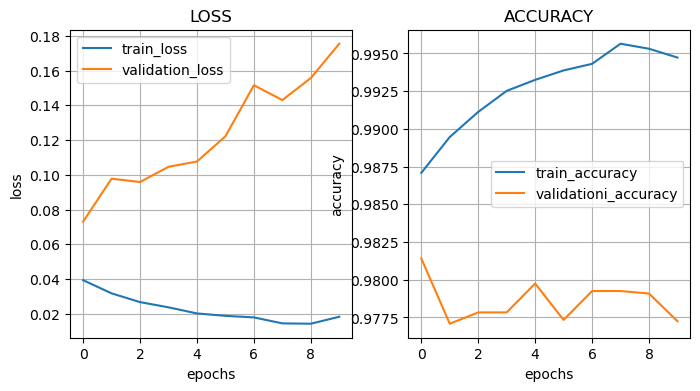

In [24]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label= 'validation_loss')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.title('ACCURACY')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(result.history['accuracy'], label='train_accuracy')
plt.plot(result.history['val_accuracy'], label= 'validationi_accuracy')
plt.legend(loc='best')

In [25]:
ret_val= model.predict(X_test.reshape(-1,28,28,1))

313/313 [==============================] - 1s 3ms/step


In [26]:
print(ret_val.shape)

(10000, 10)


In [27]:
pred_val= np.argmax(ret_val, axis=1)
pred_comp_val= np.equal(pred_val, y_test)

In [28]:
pred_comp_val

array([ True,  True,  True, ...,  True,  True,  True])

In [32]:
index_label_pred_list= [[idx, y_test[idx], pred_val[idx]] for idx, result in enumerate(pred_comp_val) if result==False]

In [33]:
print(len(index_label_pred_list))

258


In [34]:
print(index_label_pred_list)

[[18, 3, 5], [62, 9, 5], [78, 9, 8], [92, 9, 4], [95, 4, 9], [119, 2, 7], [175, 7, 1], [211, 5, 3], [247, 4, 6], [259, 6, 0], [266, 8, 0], [321, 2, 7], [340, 5, 3], [381, 3, 7], [445, 6, 0], [479, 9, 8], [528, 3, 2], [571, 4, 9], [578, 3, 7], [593, 9, 7], [624, 2, 1], [659, 2, 1], [667, 7, 1], [717, 0, 6], [740, 4, 9], [844, 8, 7], [882, 9, 7], [883, 3, 5], [924, 2, 7], [938, 3, 5], [939, 2, 0], [947, 8, 9], [965, 6, 0], [1014, 6, 5], [1033, 8, 1], [1039, 7, 3], [1068, 8, 4], [1107, 9, 5], [1112, 4, 6], [1182, 6, 5], [1202, 8, 6], [1206, 7, 2], [1226, 7, 2], [1232, 9, 4], [1247, 9, 0], [1260, 7, 1], [1312, 8, 9], [1319, 8, 0], [1326, 7, 8], [1393, 5, 3], [1394, 8, 7], [1414, 9, 7], [1415, 8, 5], [1425, 8, 4], [1530, 8, 7], [1531, 3, 5], [1549, 4, 6], [1553, 9, 3], [1554, 9, 7], [1559, 9, 7], [1611, 3, 6], [1654, 2, 3], [1678, 2, 0], [1681, 3, 7], [1686, 8, 6], [1709, 9, 5], [1717, 8, 0], [1754, 7, 2], [1790, 2, 1], [1828, 3, 7], [1838, 1, 2], [1871, 2, 3], [1878, 8, 3], [1901, 9, 4], [

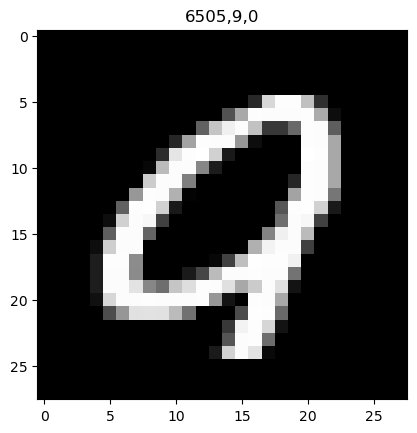

In [44]:
false_data_index= np.random.randint(len(index_label_pred_list))
mnist_index= index_label_pred_list[false_data_index][0] # 틀린 이미지의 인덱스
label= index_label_pred_list[false_data_index][1]
pred= index_label_pred_list[false_data_index][2]

img= X_test[mnist_index].reshape(28,28)

title= str(mnist_index) +','+ str(label) +','+str(pred)
plt.title(title)
plt.imshow(img, cmap='gray')

# 4. Simple CNN

#### C-> P -> C-> P ->F ->D ->D
- c: convolution
- p: pooling
- f: full connected / flatten
- d: dense

In [45]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test)= mnist.load_data()

X_train= X_train/255
X_test= X_test/255

X_trian= X_train.reshape(-1,28,28,1)
X_test= X_test.reshape(-1,28,28,1)

In [46]:
model= Sequential()

#### 1st Convolution Layer
model.add(Conv2D(filters=32, kernel_size=3, padding='SAME', 
                 input_shape=(28,28,1), activation='relu'))
model.add(MaxPool2D(padding='SAME'))

#### 2nd Convolution Layer
model.add(Conv2D(filters=32, kernel_size=3, padding='SAME', 
                 input_shape=(28,28,1), activation='relu'))
model.add(MaxPool2D(padding='SAME'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 1568)              0         
                                                                 
 dense_7 (Dense)             (None, 32)               

In [48]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=1000)

Epoch 1/20
48/48 [==============================] - 11s 219ms/step - loss: 0.5439 - accuracy: 0.8204 - val_loss: 0.1100 - val_accuracy: 0.9668
Epoch 2/20
48/48 [==============================] - 10s 217ms/step - loss: 0.0845 - accuracy: 0.9741 - val_loss: 0.0652 - val_accuracy: 0.9818
Epoch 3/20
48/48 [==============================] - 10s 216ms/step - loss: 0.0564 - accuracy: 0.9825 - val_loss: 0.0551 - val_accuracy: 0.9837
Epoch 4/20
48/48 [==============================] - 10s 218ms/step - loss: 0.0399 - accuracy: 0.9878 - val_loss: 0.0530 - val_accuracy: 0.9853
Epoch 5/20
48/48 [==============================] - 11s 224ms/step - loss: 0.0314 - accuracy: 0.9902 - val_loss: 0.0482 - val_accuracy: 0.9851
Epoch 6/20
48/48 [==============================] - 11s 223ms/step - loss: 0.0251 - accuracy: 0.9922 - val_loss: 0.0460 - val_accuracy: 0.9877
Epoch 7/20
48/48 [==============================] - 11s 224ms/step - loss: 0.0212 - accuracy: 0.9932 - val_loss: 0.0548 - val_accuracy: 0.9864

In [49]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0562 - accuracy: 0.9885


[0.05616602301597595, 0.9884999990463257]

# 5. Deep CNN
- C-P-C-P-C-P-F-D-D

In [ ]:
(X_train, y_train), (X_test, y_test)= mnist.load_data()

X_train= X_train/255
X_test= X_test/255

X_trian= X_train.reshape(-1,28,28,1)
X_test= X_test.reshape(-1,28,28,1)

model= Sequential()

#### 1st Convolution Layer
model.add(Conv2D(filters=32, kernel_size=3, padding='SAME', 
                 input_shape=(28,28,1), activation='relu'))
model.add(MaxPool2D(padding='SAME'))
model.add(Dropout(0.25))

#### 2nd Convolution Layer
model.add(Conv2D(filters=64, kernel_size=3, padding='SAME', 
                 input_shape=(28,28,1), activation='relu'))
model.add(MaxPool2D(padding='SAME'))
model.add(Dropout(0.25))

#### 3rd Convolution Layer
model.add(Conv2D(filters=128, kernel_size=3, padding='SAME', 
                 input_shape=(28,28,1), activation='relu'))
model.add(MaxPool2D(padding='SAME'))
model.add(Dropout(0.25))

model.summary()

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

In [53]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=1000)

Epoch 1/20
48/48 [==============================] - 14s 272ms/step - loss: 0.0578 - accuracy: 0.9847 - val_loss: 0.0412 - val_accuracy: 0.9902
Epoch 2/20
48/48 [==============================] - 13s 279ms/step - loss: 0.0583 - accuracy: 0.9848 - val_loss: 0.0372 - val_accuracy: 0.9905
Epoch 3/20
48/48 [==============================] - 14s 282ms/step - loss: 0.0563 - accuracy: 0.9851 - val_loss: 0.0360 - val_accuracy: 0.9913
Epoch 4/20
48/48 [==============================] - 13s 280ms/step - loss: 0.0559 - accuracy: 0.9851 - val_loss: 0.0388 - val_accuracy: 0.9909
Epoch 5/20
48/48 [==============================] - 13s 277ms/step - loss: 0.0561 - accuracy: 0.9851 - val_loss: 0.0368 - val_accuracy: 0.9917
Epoch 6/20
48/48 [==============================] - 13s 277ms/step - loss: 0.0560 - accuracy: 0.9851 - val_loss: 0.0332 - val_accuracy: 0.9921
Epoch 7/20
48/48 [==============================] - 13s 281ms/step - loss: 0.0533 - accuracy: 0.9854 - val_loss: 0.0351 - val_accuracy: 0.9913

In [54]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0309 - accuracy: 0.9910


[0.030908918008208275, 0.9909999966621399]

# 6. 실습

In [55]:
'''
1. fashion mnist 사용
2. C P C P C P F D
3. 최소 90점 이상의 성능
4. 과적합 최소화
'''

'\n1. fashion mnist 사용\n2. C P C P C P F D\n3. 최소 90점 이상의 성능\n4. 과적합 최소화\n'

In [ ]:
'''
1. fashion mnist 사용
2. C C P C C P F D
3. 최소 90점 이상의 성능
4. 과적합 최소화
'''

In [ ]:
'''
1. CPCPCP, CCPCCPCCP 등 다양한 아키텍쳐로 구현해서 과적합을 최소로 하는 80이상의 정확도를 가진 모델을 만든 후 저장

model.save('data/cifar10_accuracy_81v1.h5')
'''

In [56]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test)= cifar10.load_data()

170498071/170498071 [==============================] - 22s 0us/step


In [57]:
print(X_train.shape, X_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


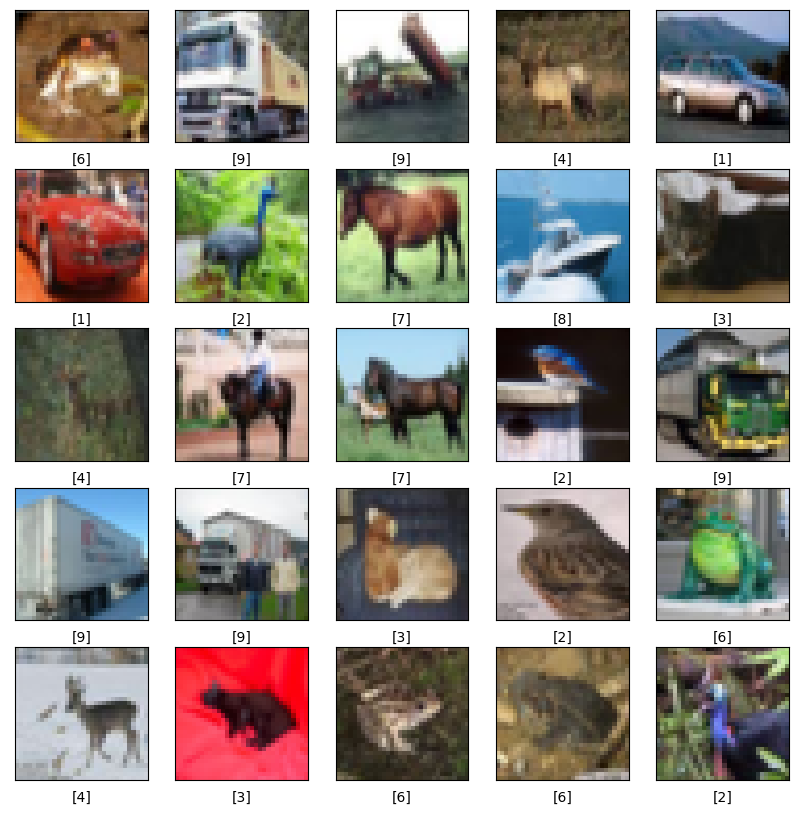

In [58]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(str(y_train[i]))

In [60]:
# X_train= X_train/255
# X_test= X_test/255

# X_trian= X_train.reshape(-1,28,28,1)
# X_test= X_test.reshape(-1,28,28,1)

ValueError: cannot reshape array of size 153600000 into shape (28,28,1)

In [67]:
model= Sequential()

#### 1st Convolution Layer
model.add(Conv2D(filters=32, kernel_size=3, padding='SAME', 
                 input_shape=(32,32,3), activation='relu'))
model.add(MaxPool2D(padding='SAME'))

#### 2nd Convolution Layer
model.add(Conv2D(filters=32, kernel_size=3, padding='SAME', 
                 input_shape=(32,32,3), activation='relu'))
model.add(MaxPool2D(padding='SAME'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 dense_19 (Dense)            (None, 32)              

In [69]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=1000)

Epoch 1/20
40/40 [==============================] - 12s 295ms/step - loss: 2.1839 - accuracy: 0.1883 - val_loss: 1.9707 - val_accuracy: 0.2734
Epoch 2/20
40/40 [==============================] - 13s 319ms/step - loss: 1.8157 - accuracy: 0.3277 - val_loss: 1.7541 - val_accuracy: 0.3409
Epoch 3/20
40/40 [==============================] - 13s 327ms/step - loss: 1.6294 - accuracy: 0.3952 - val_loss: 1.6051 - val_accuracy: 0.4136
Epoch 4/20
40/40 [==============================] - 13s 316ms/step - loss: 1.5549 - accuracy: 0.4264 - val_loss: 1.5210 - val_accuracy: 0.4463
Epoch 5/20
40/40 [==============================] - 12s 313ms/step - loss: 1.5106 - accuracy: 0.4451 - val_loss: 1.5044 - val_accuracy: 0.4537
Epoch 6/20
40/40 [==============================] - 13s 324ms/step - loss: 1.4835 - accuracy: 0.4596 - val_loss: 1.4668 - val_accuracy: 0.4619
Epoch 7/20
40/40 [==============================] - 13s 324ms/step - loss: 1.4691 - accuracy: 0.4651 - val_loss: 1.4679 - val_accuracy: 0.4683

In [70]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.3413 - accuracy: 0.5181


[1.3413145542144775, 0.5181000232696533]

#### C-C-P-C-C-P-C-P-C-P-F-D-D
- 32-32-64-64-128-128-32-32
- Adam(0.001)
- epochs(50), batch_size(100)
- loss: 0.4891 - accuracy: 0.8300 - val_loss: 0.5796 - val_accuracy: 0.8103
- loss: 0.6002 - accuracy: 0.8070

#### C-C-P-C-C-P-C-P-C-P-F-D-D
- 32-32-64-64-128-128-32-64
- Adam(0.001)
- epochs(50), batch_size(100)
- loss: 0.4996 - accuracy: 0.8264 - val_loss: 0.5729 - val_accuracy: 0.8104
- loss: 0.5958 - accuracy: 0.8015

#### C-C-P-C-C-P-C-P-C-P-F-D-D-D
- 32-32-64-64-128-128-32-32-32
- Adam(0.001)
- epochs(50), batch_size(100)
- loss: 0.4517 - accuracy: 0.8427 - val_loss: 0.5315 - val_accuracy: 0.8246
- loss: 0.5624 - accuracy: 0.8192
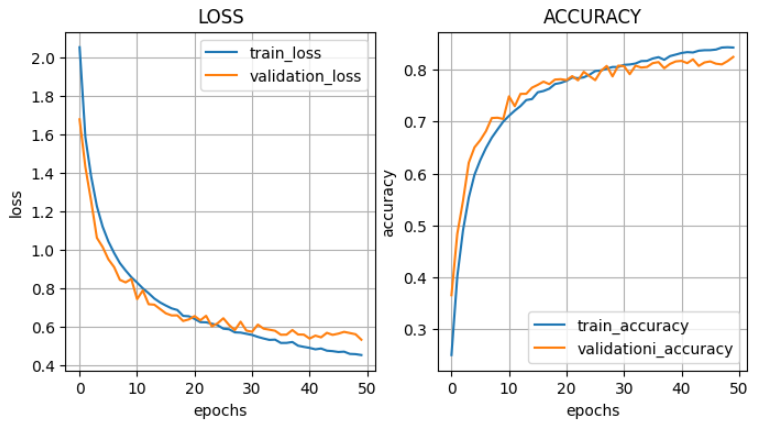

#### C-C-P-C-C-P-C-P-C-P-F-D-D
- 32-32-64-64-128-128-32-32
- Adam(0.001)
- epochs(50), batch_size(64)

#### C-C-P-C-C-P-C-P-C-P-F-D-D
- 32-32-64-64-128-128-32-32
- Adam(0.001)
- epochs(70), batch_size(64)


